<a href="https://colab.research.google.com/github/mokoron/productstar/blob/main/NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!pip install transformers[torch] accelerate -U

  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (9

In [3]:
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # классический SVM работает достаточно долго, воспользуемся линейным
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset #для более удобной работы с датасетами и правильного кодирования данных
from transformers import pipeline
import torch

In [4]:
# начем с того, что загрузим данные
data_train=pd.read_csv('twitter_training.csv',header=None )
data_test=pd.read_csv('twitter_validation.csv', header=None)

In [5]:
data_train.columns = ["id", "object", "sentiment", "text"]
data_test.columns = ["id", "object", "sentiment", "text"]

In [6]:
data_train.head()

,id,object,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
# уберем из работы все "нулевые" тексты
data_train=data_train[data_train['text'].str.len()!=0]

In [8]:
# Функция для предобработки текста
def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = str(text)
    text = text.lower()
    # Можно добавить другие шаги предобработки, например удаление стоп-слов
    return text



# Применение предобработки к тренировочным и тестовым данным
data_train['text'] = data_train['text'].apply(preprocess_text)
data_test['text'] = data_test['text'].apply(preprocess_text)


print(data_train['text'])

0        im getting on borderlands and i will murder yo...
1        i am coming to the borders and i will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    just realized that the windows partition of my...
74678    just realized that my mac window partition is ...
74679    just realized the windows partition of my mac ...
74680    just realized between the windows partition of...
74681    just like the windows partition of my mac is l...
Name: text, Length: 74682, dtype: object


## SVM

In [9]:
# Разделение тренировочных данных на тренировочную и валидационную части
X_train, X_val, y_train, y_val = train_test_split(data_train['text'], data_train['sentiment'], test_size=0.2, random_state=42)

# Создание и обучение модели SVM
svm_model = make_pipeline(TfidfVectorizer(), LinearSVC())
svm_model.fit(X_train, y_train)

# Оценка модели на валидационном наборе
y_pred_svm = svm_model.predict(X_val)
print("SVM Classification Report:")
print(classification_report(y_val, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.90      0.81      0.85      2592
    Negative       0.88      0.89      0.88      4519
     Neutral       0.86      0.85      0.86      3596
    Positive       0.84      0.89      0.86      4230

    accuracy                           0.87     14937
   macro avg       0.87      0.86      0.86     14937
weighted avg       0.87      0.87      0.87     14937



In [10]:
# Применение SVM модели
y_test_pred_svm = svm_model.predict(data_test['text'])
data_test['sentiment_pred_svm'] = y_test_pred_svm

data_test.head(10)

,id,object,sentiment,text,sentiment_pred_svm
0,3364,Facebook,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant
1,352,Amazon,Neutral,bbc news - amazon boss jeff bezos rejects clai...,Neutral
2,8312,Microsoft,Negative,@microsoft why do i pay for word when it funct...,Negative
3,4371,CS-GO,Negative,"csgo matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,now the president is slapping americans in the...,Neutral
5,6273,FIFA,Negative,hi @eahelp i’ve had madeleine mccann in my cel...,Negative
6,7925,MaddenNFL,Positive,thank you @eamaddennfl!! \n\nnew te austin hoo...,Positive
7,11332,TomClancysRainbowSix,Positive,"rocket league, sea of thieves or rainbow six: ...",Irrelevant
8,1107,AssassinsCreed,Positive,my ass still knee-deep in assassins creed odys...,Positive
9,2069,CallOfDuty,Negative,fix it jesus ! please fix it ! what in the wor...,Negative


In [11]:
# Создание и обучение модели Naive Bayes
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)

# Оценка модели на валидационном наборе
y_pred_nb = nb_model.predict(X_val)
print("Naive Bayes Classification Report:")
print(classification_report(y_val, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.97      0.41      0.58      2592
    Negative       0.64      0.91      0.75      4519
     Neutral       0.82      0.62      0.70      3596
    Positive       0.73      0.82      0.77      4230

    accuracy                           0.72     14937
   macro avg       0.79      0.69      0.70     14937
weighted avg       0.77      0.72      0.71     14937



In [12]:
# Применение Naive Bayes модели
y_test_pred_nb = nb_model.predict(data_test['text'])
data_test['sentiment_pred_nb'] = y_test_pred_nb

data_test.head(10)

,id,object,sentiment,text,sentiment_pred_svm,sentiment_pred_nb
0,3364,Facebook,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant,Irrelevant
1,352,Amazon,Neutral,bbc news - amazon boss jeff bezos rejects clai...,Neutral,Neutral
2,8312,Microsoft,Negative,@microsoft why do i pay for word when it funct...,Negative,Negative
3,4371,CS-GO,Negative,"csgo matchmaking is so full of closet hacking,...",Negative,Negative
4,4433,Google,Neutral,now the president is slapping americans in the...,Neutral,Neutral
5,6273,FIFA,Negative,hi @eahelp i’ve had madeleine mccann in my cel...,Negative,Negative
6,7925,MaddenNFL,Positive,thank you @eamaddennfl!! \n\nnew te austin hoo...,Positive,Positive
7,11332,TomClancysRainbowSix,Positive,"rocket league, sea of thieves or rainbow six: ...",Irrelevant,Positive
8,1107,AssassinsCreed,Positive,my ass still knee-deep in assassins creed odys...,Positive,Positive
9,2069,CallOfDuty,Negative,fix it jesus ! please fix it ! what in the wor...,Negative,Negative


# Классификация с помощью BERT

In [13]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, EarlyStoppingCallback

In [32]:
from sklearn.preprocessing import LabelEncoder   # загрузим LabelEncoder из sklearn.preprocessing, чтобы преобразовать строковые метки в числовые.

# Загрузка данных
train_df = data_train.head(5000)
valid_df = data_test
test_df = data_train.tail(50)

# Разделим данные на текст и метки (тональность)
train_texts = train_df['text'].tolist()
train_labels = train_df['sentiment'].tolist()
valid_texts = valid_df['text'].tolist()
valid_labels = valid_df['sentiment'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['sentiment'].tolist()

# Конвертация строковых меток в числовые
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# Проведем токенизацию текста с помощью предобученного токенизатора BERT
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Токенизация текста
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=50)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=50)
test_encodings = tokenizer(test_texts, return_tensors='pt', padding=True, truncation=True, max_length=50)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
# Создадим класс Dataset для PyTorch, чтобы можно было использовать наши данные для обучения модели.

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TwitterDataset(train_encodings, train_labels)
valid_dataset = TwitterDataset(valid_encodings, valid_labels)
test_dataset = TwitterDataset(test_encodings, test_labels)

In [16]:
# Проверка содержимого датасетов перед началом обучения, чтобы убедиться, что метки присутствуют.
print("Пример из тренировочного набора данных:", train_dataset[0])
print("Пример из валидационного набора данных:", valid_dataset[0])

Пример из тренировочного набора данных: {'input_ids': tensor([  101, 10047,  2893,  2006,  3675,  8653,  1998,  1045,  2097,  4028,
         2017,  2035,  1010,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'label': tensor(3)}
Пример из валидационного набора данных: {'input_ids': tensor([  101,  1045,  3855,  2006,  9130,  2008,  1045,  2001,  8084,  2005,
        14354,

In [17]:
# Загрузка модели BERT для классификации последовательностей
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Использование DistilBERT вместо BERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))


# Настройка параметров тренировки
training_args = TrainingArguments(
    output_dir='./results',          # выходная директория
    num_train_epochs=3,              # количество эпох
    per_device_train_batch_size=8,  # размер батча для тренировки
    per_device_eval_batch_size=8,   # размер батча для оценки
    warmup_steps=50,                # количество шагов для разогрева: в течение первых 500 шагов скорость обучения будет постепенно увеличиваться от очень маленького значения до целевого значения.
    weight_decay=0.01,               # коэффициент регуляризации: к функции потерь добавляется штраф за весовые коэффициенты модели, пропорциональный их квадрату, что помогает предотвратить переобучение
    logging_dir='./logs',            # директория для логов
    logging_steps=10,
    learning_rate=5e-5,             # зададим скорость обучения
)

from transformers import DataCollatorWithPadding
# Добавление data collator (стандартный Data Collator для моделей Transformers, который использует токенизатор для выравнивания длин последовательностей и добавления заполнения там, где это необходимо.)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Создание собственно
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Удостоверьтесь, что метки присутствуют в inputs
        if labels is None:
            raise ValueError("Метки отсутствуют в входных данных!")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Создание тренера с data collator
trainer = CustomTrainer(
    model=model,                         # модель для тренировки
    args=training_args,                  # параметры тренировки
    train_dataset=train_dataset,         # тренировочный набор данных
    eval_dataset=valid_dataset,          # валидационный набор данных
    data_collator=data_collator          # collator для форматирования данных
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
trainer.train()

Step,Training Loss
10,1.396100
20,1.383200
30,1.360700
40,1.311600
50,1.301500
60,1.305400
70,1.205100
80,1.184400
90,1.199500
100,0.970100


TrainOutput(global_step=1875, training_loss=0.3479663175796469, metrics={'train_runtime': 6308.3781, 'train_samples_per_second': 2.378, 'train_steps_per_second': 0.297, 'total_flos': 194050962000000.0, 'train_loss': 0.3479663175796469, 'epoch': 3.0})

In [19]:
# Оценка модели
eval_result = trainer.evaluate()
print(eval_result)

{'eval_loss': 2.7729618549346924, 'eval_runtime': 94.5475, 'eval_samples_per_second': 10.577, 'eval_steps_per_second': 1.322, 'epoch': 3.0}


In [20]:
# Переводим модель в режим оценки
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [33]:
# Тестовые данные
print("Пример из тестового набора данных:", test_encodings)

Пример из тестового набора данных: {'input_ids': tensor([[  101,  3828,  1002,  ...,  2595, 14246,   102],
        [  101,  2084,  1002,  ...,  2188,  1010,   102],
        [  101,  2293,  2673,  ...,     0,     0,     0],
        ...,
        [  101,  2074,  3651,  ...,     0,     0,     0],
        [  101,  2074,  3651,  ...,     0,     0,     0],
        [  101,  2074,  2066,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [34]:
# Используем модель для предсказания меток для тестовых данных

with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits

# Получим предсказанные метки
predicted_class_ids = torch.argmax(logits, dim=1)
predicted_labels = predicted_class_ids.numpy()

print(predicted_labels)


[0 3 3 3 3 3 3 2 2 1 3 1 2 1 1 1 1 1 1 1 1 2 2 1 2 3 2 2 2 2 2 2 1 1 1 1 1
 1 2 3 2 2 2 3 1 1 1 1 1 1]


In [36]:
print(test_labels)

[2 2 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1
 1 3 3 3 3 3 3 3 3 3 3 3 3]


In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Пример истинных меток для новых данных
true_labels = test_labels

# Оценка метрик
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.44
Precision: 0.5724782608695653
Recall: 0.44
F1-Score: 0.4475966386554622
Confusion Matrix:
[[0 0 0 0]
 [0 8 3 1]
 [1 6 6 1]
 [0 9 7 8]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Кластеризация K-means

In [2]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Кластеризация K-means

In [3]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [34]:
# Функция для преобразования значений в строки и обработки NaN
def safe_str(x):
    if pd.isna(x):
        return ''
    return str(x)


In [35]:

# Функция векторизации текста
def vectorize_texts(df):
    # Используем модель 'paraphrase-multilingual-MiniLM-L12-v2'
    model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
    model = SentenceTransformer(model_name)

    # Векторизация столбцов 'text'
    texts = (df['text'].apply(safe_str)).tolist()
    vectors = model.encode(texts)

    return vectors


In [36]:
# Векторизация текстов
vectors = vectorize_texts(data_test)

def kmeans_clustering(vectors, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)

    # Визуализация
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='viridis')
    plt.title('K-Means Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

    return clusters


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


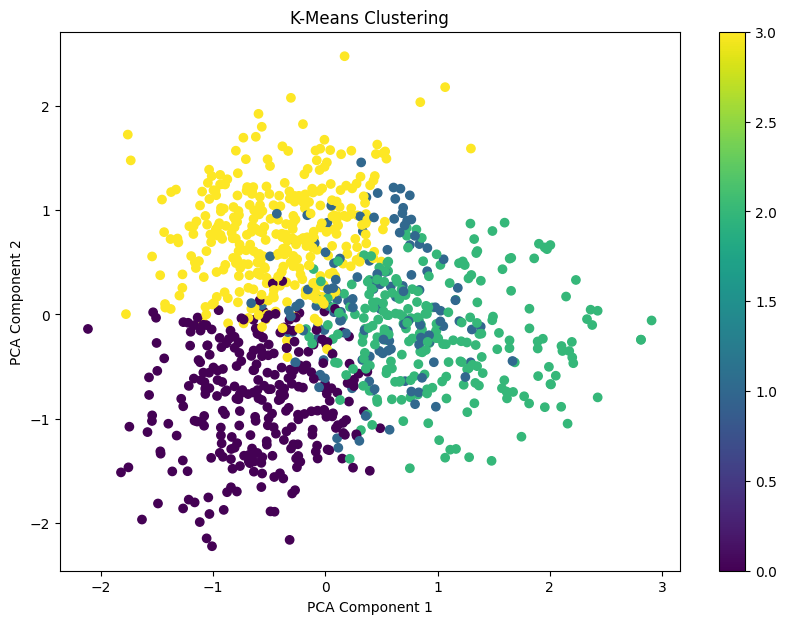

In [38]:
kmeans_clusters = kmeans_clustering(vectors, n_clusters=4)
data_test['kmeans_cluster'] = kmeans_clusters

In [40]:
data_test.head(10)

,id,object,sentiment,text,sentiment_pred_svm,sentiment_pred_nb,kmeans_cluster
0,3364,Facebook,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant,Irrelevant,0
1,352,Amazon,Neutral,bbc news - amazon boss jeff bezos rejects clai...,Neutral,Neutral,0
2,8312,Microsoft,Negative,@microsoft why do i pay for word when it funct...,Negative,Negative,0
3,4371,CS-GO,Negative,"csgo matchmaking is so full of closet hacking,...",Negative,Negative,3
4,4433,Google,Neutral,now the president is slapping americans in the...,Neutral,Neutral,0
5,6273,FIFA,Negative,hi @eahelp i’ve had madeleine mccann in my cel...,Negative,Negative,3
6,7925,MaddenNFL,Positive,thank you @eamaddennfl!! \n\nnew te austin hoo...,Positive,Positive,2
7,11332,TomClancysRainbowSix,Positive,"rocket league, sea of thieves or rainbow six: ...",Irrelevant,Positive,3
8,1107,AssassinsCreed,Positive,my ass still knee-deep in assassins creed odys...,Positive,Positive,1
9,2069,CallOfDuty,Negative,fix it jesus ! please fix it ! what in the wor...,Negative,Negative,3
